In [49]:
import tensorflow as tf
keras = tf.keras
import warnings
warnings.filterwarnings("ignore")
import gensim, re
import numpy as np
import pandas as pd
import openpyxl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Bidirectional, Dropout, Conv1D
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [50]:
!pip install bltk
!pip install pandas
import pandas as pd
from bltk.langtools import remove_stopwords
import regex as re
from bltk.langtools import Tokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
#df=pd.read_excel('/content/drive/MyDrive/suicide/suicide_data2.xlsx')
#main_data = pd.read_excel( "/content/drive/MyDrive/suicide/suicide_data2.xlsx" )
df=pd.read_excel('/content/drive/MyDrive/suicide/suicide_data2.xlsx')
main_data = pd.read_excel( "/content/drive/MyDrive/suicide/suicide_data2.xlsx" )
labels = main_data['label'].tolist()
df.head()

,text,label
0,আমি একদিন নিজেকে মেরে ফেলব এই বিষয়টি আমি নিশ...,1
1,বেচে থাকার কোন কারণ আমি ভাবতে পারি না। জীবনের ...,1
2,আমি কমপক্ষে ১ বছর ধরে সুইসাইড করার কথা ভাবছি। ...,1
3,আমার আর বাঁচার দরকার নেই। আমি ওর সাথে সম্পর্ক...,1
4,আমি এভাবে আর বাঁচব না। আমার হতাশা ও আত্মহত্যার...,1


In [31]:
from bltk.langtools.banglachars import (vowels,
                                        vowel_signs,
                                        consonants,
                                        digits,
                                        operators,
                                        punctuations,
                                        others)
print(f'Vowels: {vowels}')
print(f'Vowel signs: {vowel_signs}')
print(f'Consonants: {consonants}')
print(f'Digits: {digits}')
print(f'Operators: {operators}')
print(f'Punctuation marks: {punctuations}')
print(f'Others: {others}')

Vowels: ['অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'ঌ', 'এ', 'ঐ', 'ও', 'ঔ']
Vowel signs: ['া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ৄ', 'ে', 'ৈ', 'ো', 'ৌ']
Consonants: ['ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', 'ড়', 'ঢ়', 'য়', 'ৎ', 'ং', 'ঃ', 'ঁ']
Digits: ['০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯']
Operators: ['=', '+', '-', '*', '/', '%', '<', '>', '×', '÷']
Punctuation marks: ['।', ',', ';', ':', '?', '!', "'", '.', '"', '-', '[', ']', '{', '}', '(', ')', '–', '—', '―', '~']
Others: ['৳', '৺', '্', 'ঀ', 'ঽ', '#', '$']


In [32]:
df.shape[0]

1402

In [33]:
def punc(tokens):
  valid_tokens=[]
  for token in tokens:
    if token not in punctuations:
      valid_tokens.append(token)
  tokens=valid_tokens
  return tokens

In [34]:
new_list=[]
for c in vowels:
  new_list.append(c)
for c in vowel_signs:
  new_list.append(c)
for c in consonants:
  new_list.append(c)
new_list.append('্')
new_list.append('য়')
def tokenize(text):
    token=[]
    text=str(text)
    #print(text)
    new_text=""
    for c in text:
      if c in new_list:
        new_text=new_text+c
      else:
        new_text=new_text+' '
    tokenizer = Tokenizer()
    text=new_text
    words=tokenizer.word_tokenizer(text)
    for word in words:
      if word not in token:
        siz=0
        for c in word:
          siz=siz+1
        if siz>0:
          token.append(word)
    return token

In [35]:
def stp_remove(tkn):
  words=remove_stopwords(tkn, level='soft')
  return words

In [36]:
df2=pd.read_excel('/content/drive/MyDrive/suicide/rules.xlsx')
pd.set_option('display.max_rows', None)
df2.head()
#print(df2)

,rule
0,ই
1,ও
2,তো
3,কে
4,তে


In [37]:
def stemming(text, pattern):
    mi=min(len(text),len(pattern))
    cnt=0
    len_text=len(text)
    len_pattern=len(pattern)
    cnt=-2
    for i in range(mi):
      if(text[len_text-(i+1)]!=pattern[len_pattern-(i+1)]):
        break
      cnt=i
    len_text=len_text-cnt
    txt=text
    if cnt+1==mi:
      txt = text[0:len_text-1]
    return txt

In [51]:
posts= list()
for text in df["text"]:
    text=str(text)
    text=tokenize(text)
    text=punc(text)
    text=stp_remove(text)
    new_tokens=[]
    for txt in text:
       temp=txt
       for rule in df2["rule"]:
           temp=stemming(txt,rule)
           if temp!=txt:
               break
       if len(temp)>0:
          new_tokens.append(temp)
    posts.append(new_tokens)
cleaned_data=posts

In [16]:
print(cleaned_data)

[['একদিন', 'মেরে', 'ফেলব', 'বিষয', 'নিশ্চিত', 'জীবন', 'অস্তিত্বহীন', 'বন্ধু', 'রয', 'েছে', 'পরিবার', 'বিচ্ছিন্ন', 'হয', 'েছি', 'সবসময়', 'বিষাক্ত', 'চিন্তায', 'ডুবে', 'আছি'], ['বেচে', 'ভাবতে', 'পারি', 'জীবনের', 'কোনও', 'ক্ষেত্রেই', 'স্থিতিশীলতা', 'আতঙ্কিত', 'হয', 'ে', 'পড', 'ছি', 'তাছাড়া', 'বাবা', 'মা', 'চায়', 'জীবনটি', 'খারাপ', 'পারে', 'অনুভব', 'করেছি', 'মরতে', 'প্রস্তুত'], ['কমপক্ষে', 'বছর', 'ধরে', 'সুইসাইড', 'করার', 'কথা', 'ভাবছি', 'আজ', 'তম', 'জন্মদিন', 'বিষয', 'ইদানীং', 'অত্যন্ত', 'খারাপ', 'যাছে', 'চাকরি', 'হারিয', 'েছি', 'এমন', 'দেশে', 'বাস', 'করি', 'যেখানে', 'বেকারত্বের', 'হার', 'বেশি', 'কাজের', 'ক্ষেত্রের', 'অনেক', 'সুযোগ', 'এমনকি', 'এটির', 'বাইরেও', 'কাজ', 'খুঁজে', 'পাওয', 'া', 'শক্ত', 'হতাশ', 'বোধ', 'আত্মঘাতী', 'চিন্তাভাবনাগুলিকে', 'তুলেছে'], ['আর', 'বাঁচার', 'দরকার', 'ওর', 'সাথে', 'সম্পর্ক', 'ছিন্ন', 'করেছি', 'পরিবারের', 'সদস্যদের', 'দূরে', 'ঠেলে', 'দিয', 'েছি', 'কোথাও', 'জায়গা'], ['এভাবে', 'আর', 'বাঁচব', 'হতাশা', 'ও', 'আত্মহত্যার', 'চেষ্টার', 'অনেক', 'ইতিহাস', 'রয', 'েছে', '

In [52]:
from tensorflow.keras.preprocessing.text import Tokenizer
features = 100
tokenizer = Tokenizer(num_words=features)

In [53]:

tokenizer.fit_on_texts(cleaned_data)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(cleaned_data)

maxlen=10
padType='post'

X = pad_sequences(sequences, maxlen=maxlen, padding="post", truncating="post")
y = np.asarray(pd.get_dummies(labels))

In [54]:
len(X), len(y)

(1402, 1402)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True)

In [56]:
def get_model(num_of_layer):
    model = Sequential()
    model.add(Embedding(4000, features, input_length = X.shape[1]))
    
    for i in range(num_of_layer):
        if i>0:
            model.add(GRU(features, return_sequences=True))
            
    model.add(GRU(features, return_sequences=False))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(y.shape[1], activation="softmax"))
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    # model.summary()
    return model;

In [57]:
def run_model(model, batch, epochs):
    history = model.fit(X_train, y_train, batch, epochs, validation_data=(X_test, y_test), verbose=1)
    return history

In [58]:
#plot

import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

Epoch 1/10
36/36 [==============================] - 6s 97ms/step - loss: 0.6934 - accuracy: 0.4826 - val_loss: 0.6922 - val_accuracy: 0.5125
Epoch 2/10
36/36 [==============================] - 2s 62ms/step - loss: 0.6925 - accuracy: 0.5094 - val_loss: 0.6914 - val_accuracy: 0.5160
Epoch 3/10
36/36 [==============================] - 2s 51ms/step - loss: 0.6919 - accuracy: 0.5201 - val_loss: 0.6909 - val_accuracy: 0.5374
Epoch 4/10
36/36 [==============================] - 2s 44ms/step - loss: 0.6911 - accuracy: 0.5263 - val_loss: 0.6898 - val_accuracy: 0.5480
Epoch 5/10
36/36 [==============================] - 1s 40ms/step - loss: 0.6901 - accuracy: 0.5308 - val_loss: 0.6879 - val_accuracy: 0.5516
Epoch 6/10
36/36 [==============================] - 2s 43ms/step - loss: 0.6875 - accuracy: 0.5477 - val_loss: 0.6839 - val_accuracy: 0.5836
Epoch 7/10
36/36 [==============================] - 1s 39ms/step - loss: 0.6805 - accuracy: 0.5700 - val_loss: 0.6708 - val_accuracy: 0.6192
Epoch 8/10
36

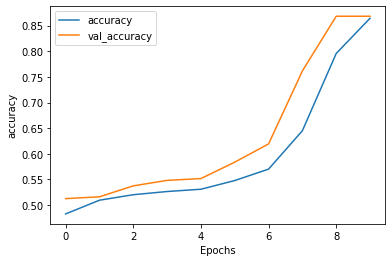

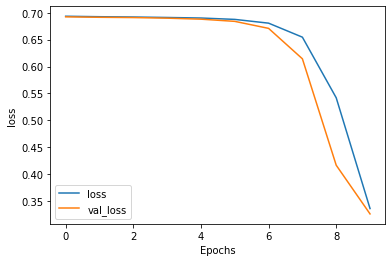

9/9 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       142
           1       0.89      0.83      0.86       139

    accuracy                           0.87       281
   macro avg       0.87      0.87      0.87       281
weighted avg       0.87      0.87      0.87       281

Epoch 1/10
36/36 [==============================] - 12s 102ms/step - loss: 0.6926 - accuracy: 0.5227 - val_loss: 0.6914 - val_accuracy: 0.5516
Epoch 2/10
36/36 [==============================] - 3s 77ms/step - loss: 0.6904 - accuracy: 0.5531 - val_loss: 0.6864 - val_accuracy: 0.6192
Epoch 3/10
36/36 [==============================] - 2s 48ms/step - loss: 0.6815 - accuracy: 0.6164 - val_loss: 0.6664 - val_accuracy: 0.7295
Epoch 4/10
36/36 [==============================] - 2s 48ms/step - loss: 0.6280 - accuracy: 0.7422 - val_loss: 0.5445 - val_accuracy: 0.7865
Epoch 5/10
36/36 [==============================] - 2s 4

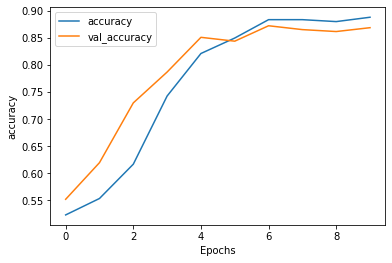

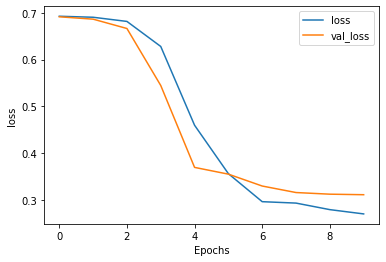

9/9 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       142
           1       0.92      0.81      0.86       139

    accuracy                           0.87       281
   macro avg       0.87      0.87      0.87       281
weighted avg       0.87      0.87      0.87       281

Epoch 1/10
36/36 [==============================] - 16s 123ms/step - loss: 0.6917 - accuracy: 0.5165 - val_loss: 0.6878 - val_accuracy: 0.5979
Epoch 2/10
36/36 [==============================] - 3s 73ms/step - loss: 0.6809 - accuracy: 0.5682 - val_loss: 0.6606 - val_accuracy: 0.6548
Epoch 3/10
36/36 [==============================] - 4s 114ms/step - loss: 0.6247 - accuracy: 0.6913 - val_loss: 0.5242 - val_accuracy: 0.8149
Epoch 4/10
36/36 [==============================] - 2s 69ms/step - loss: 0.4053 - accuracy: 0.8341 - val_loss: 0.3509 - val_accuracy: 0.8505
Epoch 5/10
36/36 [==============================] - 3s

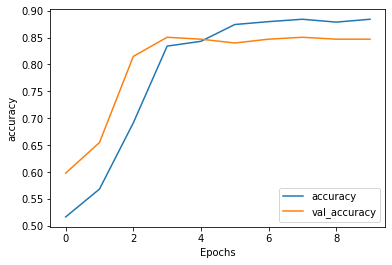

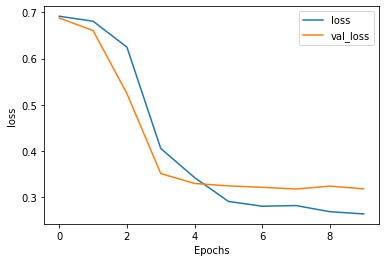

9/9 [==============================] - 2s 19ms/step
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       142
           1       0.87      0.81      0.84       139

    accuracy                           0.85       281
   macro avg       0.85      0.85      0.85       281
weighted avg       0.85      0.85      0.85       281

Epoch 1/20
36/36 [==============================] - 4s 45ms/step - loss: 0.6931 - accuracy: 0.4960 - val_loss: 0.6926 - val_accuracy: 0.5445
Epoch 2/20
36/36 [==============================] - 1s 32ms/step - loss: 0.6925 - accuracy: 0.5236 - val_loss: 0.6917 - val_accuracy: 0.5516
Epoch 3/20
36/36 [==============================] - 2s 43ms/step - loss: 0.6916 - accuracy: 0.5459 - val_loss: 0.6909 - val_accuracy: 0.4947
Epoch 4/20
36/36 [==============================] - 1s 34ms/step - loss: 0.6916 - accuracy: 0.4978 - val_loss: 0.6898 - val_accuracy: 0.4947
Epoch 5/20
36/36 [==============================] - 1s 33

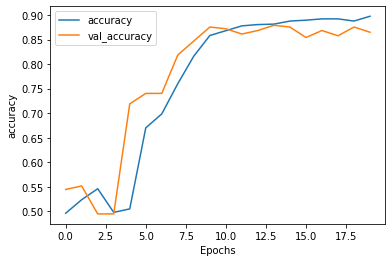

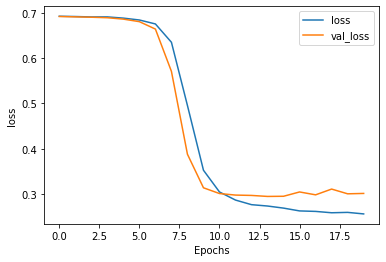

9/9 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       142
           1       0.89      0.83      0.86       139

    accuracy                           0.86       281
   macro avg       0.87      0.86      0.86       281
weighted avg       0.87      0.86      0.86       281

Epoch 1/20
36/36 [==============================] - 11s 99ms/step - loss: 0.6932 - accuracy: 0.4897 - val_loss: 0.6923 - val_accuracy: 0.4947
Epoch 2/20
36/36 [==============================] - 4s 110ms/step - loss: 0.6907 - accuracy: 0.5281 - val_loss: 0.6875 - val_accuracy: 0.6512
Epoch 3/20
36/36 [==============================] - 2s 46ms/step - loss: 0.6802 - accuracy: 0.6815 - val_loss: 0.6646 - val_accuracy: 0.7224
Epoch 4/20
36/36 [==============================] - 2s 46ms/step - loss: 0.6179 - accuracy: 0.7145 - val_loss: 0.5259 - val_accuracy: 0.8221
Epoch 5/20
36/36 [==============================] - 2s 4

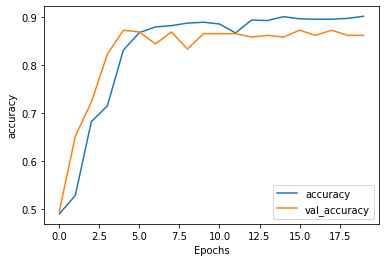

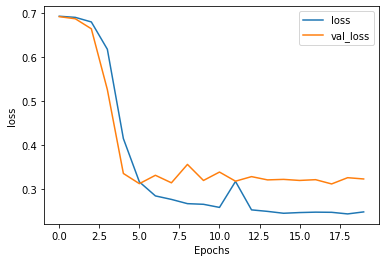

9/9 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       142
           1       0.91      0.80      0.85       139

    accuracy                           0.86       281
   macro avg       0.87      0.86      0.86       281
weighted avg       0.87      0.86      0.86       281

Epoch 1/20
36/36 [==============================] - 16s 128ms/step - loss: 0.6932 - accuracy: 0.5076 - val_loss: 0.6930 - val_accuracy: 0.4982
Epoch 2/20
36/36 [==============================] - 4s 108ms/step - loss: 0.6930 - accuracy: 0.5754 - val_loss: 0.6927 - val_accuracy: 0.6655
Epoch 3/20
36/36 [==============================] - 3s 74ms/step - loss: 0.6902 - accuracy: 0.6182 - val_loss: 0.6795 - val_accuracy: 0.4947
Epoch 4/20
36/36 [==============================] - 2s 68ms/step - loss: 0.5930 - accuracy: 0.6655 - val_loss: 0.4227 - val_accuracy: 0.8149
Epoch 5/20
36/36 [==============================] - 2s

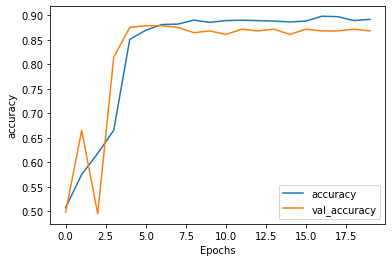

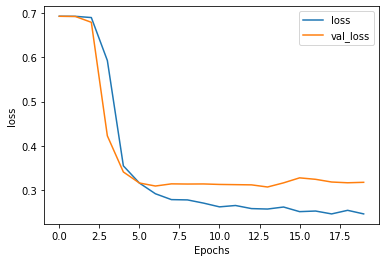

9/9 [==============================] - 2s 16ms/step
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       142
           1       0.92      0.81      0.86       139

    accuracy                           0.87       281
   macro avg       0.87      0.87      0.87       281
weighted avg       0.87      0.87      0.87       281

Epoch 1/30
36/36 [==============================] - 5s 52ms/step - loss: 0.6934 - accuracy: 0.4978 - val_loss: 0.6930 - val_accuracy: 0.4875
Epoch 2/30
36/36 [==============================] - 1s 23ms/step - loss: 0.6930 - accuracy: 0.5040 - val_loss: 0.6926 - val_accuracy: 0.4947
Epoch 3/30
36/36 [==============================] - 1s 22ms/step - loss: 0.6925 - accuracy: 0.5022 - val_loss: 0.6920 - val_accuracy: 0.4947
Epoch 4/30
36/36 [==============================] - 1s 21ms/step - loss: 0.6917 - accuracy: 0.5424 - val_loss: 0.6912 - val_accuracy: 0.4947
Epoch 5/30
36/36 [==============================] - 1s 21

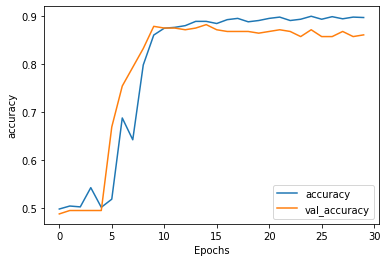

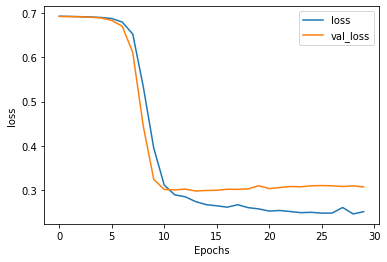

9/9 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       142
           1       0.91      0.80      0.85       139

    accuracy                           0.86       281
   macro avg       0.87      0.86      0.86       281
weighted avg       0.87      0.86      0.86       281

Epoch 1/30
36/36 [==============================] - 11s 93ms/step - loss: 0.6914 - accuracy: 0.5236 - val_loss: 0.6882 - val_accuracy: 0.5658
Epoch 2/30
36/36 [==============================] - 3s 76ms/step - loss: 0.6875 - accuracy: 0.5870 - val_loss: 0.6827 - val_accuracy: 0.6014
Epoch 3/30
36/36 [==============================] - 2s 46ms/step - loss: 0.6764 - accuracy: 0.6396 - val_loss: 0.6615 - val_accuracy: 0.5979
Epoch 4/30
36/36 [==============================] - 2s 46ms/step - loss: 0.6264 - accuracy: 0.7021 - val_loss: 0.5442 - val_accuracy: 0.8007
Epoch 5/30
36/36 [==============================] - 2s 46

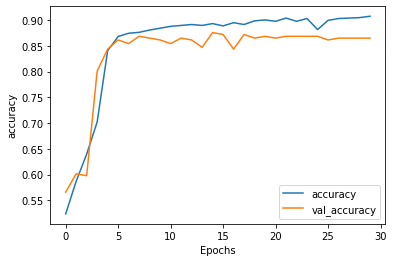

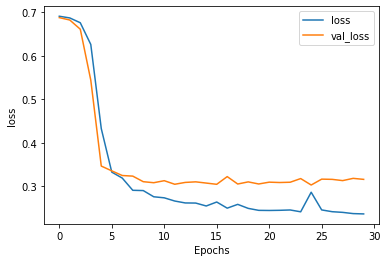

9/9 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       142
           1       0.90      0.81      0.86       139

    accuracy                           0.86       281
   macro avg       0.87      0.86      0.86       281
weighted avg       0.87      0.86      0.86       281

Epoch 1/30
36/36 [==============================] - 16s 131ms/step - loss: 0.6913 - accuracy: 0.5129 - val_loss: 0.6869 - val_accuracy: 0.5623
Epoch 2/30
36/36 [==============================] - 4s 111ms/step - loss: 0.6823 - accuracy: 0.5647 - val_loss: 0.6689 - val_accuracy: 0.6121
Epoch 3/30
36/36 [==============================] - 3s 81ms/step - loss: 0.6438 - accuracy: 0.6896 - val_loss: 0.5770 - val_accuracy: 0.8007
Epoch 4/30
36/36 [==============================] - 3s 70ms/step - loss: 0.4690 - accuracy: 0.8332 - val_loss: 0.3877 - val_accuracy: 0.8399
Epoch 5/30
36/36 [==============================] - 3s

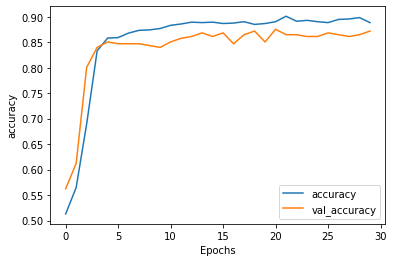

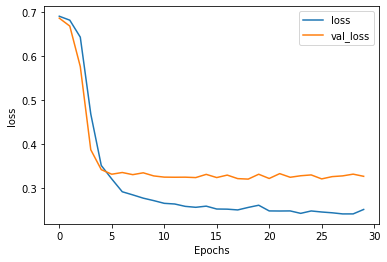

9/9 [==============================] - 2s 16ms/step
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       142
           1       0.90      0.83      0.87       139

    accuracy                           0.87       281
   macro avg       0.87      0.87      0.87       281
weighted avg       0.87      0.87      0.87       281



In [59]:
arr_batch = [32]
arr_epochs = [10,20,30]
algo_layers = [1,3,5]
output = {}
idx = 0
for batch in arr_batch:
    for epoch in arr_epochs:
        for layer in algo_layers:
            model = get_model(layer)
            history = run_model(model, batch, epoch)
            ev = model.evaluate(X_test, y_test)
            
            plot_graphs(history, "accuracy")
            plot_graphs(history, "loss")

            y_pred=model.predict(X_test) 
            y_pred=np.argmax(y_pred, axis=1)
            formated_y_test=np.argmax(y_test, axis=1)
            cm = classification_report(formated_y_test, y_pred)
            print(cm)
            
            output[idx] = {'batch':batch, 'epoch':epoch, 'num_of_layer':layer, 'acc':ev, 'cm':cm}
            idx = idx+1;

In [ ]:
output

{0: {'batch': 32,
  'epoch': 10,
  'num_of_layer': 1,
  'acc': [0.3539862334728241, 0.854092538356781],
  'cm': '              precision    recall  f1-score   support\n\n           0       0.87      0.82      0.85       137\n           1       0.84      0.88      0.86       144\n\n    accuracy                           0.85       281\n   macro avg       0.86      0.85      0.85       281\nweighted avg       0.85      0.85      0.85       281\n'},
 1: {'batch': 32,
  'epoch': 10,
  'num_of_layer': 3,
  'acc': [0.33795464038848877, 0.8469750881195068],
  'cm': '              precision    recall  f1-score   support\n\n           0       0.79      0.93      0.86       137\n           1       0.92      0.76      0.84       144\n\n    accuracy                           0.85       281\n   macro avg       0.86      0.85      0.85       281\nweighted avg       0.86      0.85      0.85       281\n'},
 2: {'batch': 32,
  'epoch': 10,
  'num_of_layer': 5,
  'acc': [0.33560237288475037, 0.861209988

In [ ]:
import json
json_object = json.dumps(output, indent = 4)
with open('model_v0.0.0_gru_dense.json', 'a') as fp:
    fp.write(json_object)

NameError: ignored